# Federal Funds Rate Forecasting Project: Neural Network Models

This Notebook contains the neural network based models for predicting the Federal Funds Rate.

5 models are developed:

1. LSTM (univariate)
2. GRU (univariate)
3. Seq2Seq (univariate)
4. CNN-LSTM Hybrid using features
5. Seq2Seq using features

Features used are the top 30 macroeconomic features from the FRED-MD file plus the 5 lags of EFFR found by partial autocorrelation.

Seq2Seq (univariate) and LSTM perform well on the valid data and are used to make the final recommended Meta Model in the next notebook.


In [6]:
## Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten,Bidirectional, TimeDistributed, Dropout, SimpleRNN, GRU, Conv1D, MaxPooling1D, RepeatVector, Input,BatchNormalization, MaxPooling1D, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow.keras import backend as K


## 1. Data Preprocessing for Neural Networks

1. Import the file with features from the first notebook.
2. Train/Valid/Test split (80%, 10%, 10%) in sequential order.
3. Min-max scale to put each feature on a scale from 0 - 1
4. shape tensors to feed into neural networks either (samples, 12, 1) for univariate or (samples, 12, 35) for models with features.

In [8]:
from google.colab import files
uploaded = files.upload()

Saving selected_df.csv to selected_df.csv


In [9]:

## Importing Data
selected_df = pd.read_csv('selected_df.csv')
ffr_df = pd.DataFrame({'FEDFUNDS' : selected_df['FEDFUNDS']})
print(selected_df.head())
print(selected_df.tail())
print(ffr_df.shape, selected_df.shape)

   IPCONGD   CUMFNS  UEMPMEAN  UEMP27OV  CLAIMSx  USGOOD  CES1021000001  \
0  65.8820  82.0672      12.9       813   351000   23374          668.3   
1  66.9695  82.1542      12.5       667   383250   23453          672.2   
2  68.3259  83.3773      12.4       714   349000   23649          686.3   
3  68.7741  84.4017      12.3       680   326000   24008          841.1   
4  68.3908  84.5590      12.1       692   327000   24082          846.8   

   MANEMP  DMANEMP  NDMANEMP  ...  AAAFFM  BAAFFM  CES2000000008  FEDFUNDS  \
0   18593    11481      7112  ...    1.71    2.47           7.77      6.70   
1   18639    11518      7121  ...    1.69    2.42           7.82      6.78   
2   18699    11556      7143  ...    1.68    2.43           7.90      6.79   
3   18772    11624      7148  ...    1.67    2.43           7.94      6.89   
4   18848    11691      7157  ...    1.33    2.13           8.03      7.36   

         date  fedfunds_lag1  fedfunds_lag2  fedfunds_lag3  fedfunds_lag9  \
0  

In [10]:
## Train/valid/split

train_data_size = int(len(selected_df)*.8)
valid_data_size = int(len(selected_df)*.1)
test_data_size = int(len(selected_df)*.1)

train_p, valid_p, test_p = selected_df[:train_data_size], selected_df[train_data_size:train_data_size+valid_data_size], selected_df[train_data_size + valid_data_size:]
train_p = train_p.reset_index(drop=True)
valid_p = valid_p.reset_index(drop=True)
test_p = test_p.reset_index(drop=True)
print(train_p.shape, valid_p.shape, test_p.shape)
train_t, valid_t, test_t = ffr_df[:train_data_size], ffr_df[train_data_size:train_data_size+valid_data_size], ffr_df[train_data_size+valid_data_size:]
train_t = train_t.reset_index(drop=True)
valid_t = valid_t.reset_index(drop=True)
test_t = test_t.reset_index(drop=True)
print(train_t.shape, valid_t.shape, test_t.shape)

(451, 37) (56, 37) (57, 37)
(451, 1) (56, 1) (57, 1)


In [12]:
X_trainp = train_p.drop(columns = ['FEDFUNDS', 'date'])
y_trainp = train_p['FEDFUNDS']
X_validp = valid_p.drop(columns = ['FEDFUNDS', 'date'])
y_validp = valid_p['FEDFUNDS']
X_testp = test_p.drop(columns = ['FEDFUNDS', 'date'])
y_testp = test_p['FEDFUNDS']

In [13]:

# Standardizing the features
feature_cols = X_trainp.columns.tolist()
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
train_x_scaled = X_trainp.copy()
valid_x_scaled = X_validp.copy()
test_x_scaled = X_testp.copy()

train_x_scaled[feature_cols] = scaler_X.fit_transform(train_x_scaled[feature_cols])
valid_x_scaled[feature_cols] = scaler_X.transform(valid_x_scaled[feature_cols])
test_x_scaled[feature_cols] = scaler_X.transform(test_x_scaled[feature_cols])

train_y_scaled = scaler_y.fit_transform(y_trainp.values.reshape(-1, 1))
valid_y_scaled = scaler_y.transform(y_validp.values.reshape(-1, 1))
test_y_scaled = scaler_y.transform(y_testp.values.reshape(-1, 1))
print(train_x_scaled.head(), valid_x_scaled.head(), test_x_scaled.head())

scaler2 = MinMaxScaler()
train_t['FEDFUNDS'] = scaler2.fit_transform(train_t[['FEDFUNDS']])
valid_t['FEDFUNDS'] = scaler2.transform(valid_t[['FEDFUNDS']])
test_t['FEDFUNDS'] = scaler2.transform(test_t[['FEDFUNDS']])

print(train_t.head(), valid_t.head(), test_t.head())

valid_y_scaled

    IPCONGD    CUMFNS  UEMPMEAN  UEMP27OV   CLAIMSx    USGOOD  CES1021000001  \
0  0.058429  0.822030  0.085526  0.054186  0.204034  0.762575       0.250552   
1  0.080749  0.825889  0.072368  0.031122  0.286907  0.773059       0.256293   
2  0.108589  0.880137  0.069079  0.038547  0.198895  0.799071       0.277050   
3  0.117788  0.925572  0.065789  0.033175  0.139792  0.846715       0.504932   
4  0.109921  0.932548  0.059211  0.035071  0.142362  0.856536       0.513323   

     MANEMP   DMANEMP  NDMANEMP  ...    T5YFFM   T10YFFM    AAAFFM    BAAFFM  \
0  0.881481  0.842737  0.956770  ...  0.779303  0.750000  0.665000  0.506605   
1  0.887160  0.849672  0.959986  ...  0.777191  0.749035  0.663333  0.502720   
2  0.894568  0.856795  0.967846  ...  0.779303  0.749035  0.662500  0.503497   
3  0.903580  0.869541  0.969632  ...  0.781415  0.750000  0.661667  0.503497   
4  0.912963  0.882099  0.972847  ...  0.752904  0.723938  0.633333  0.480186   

   CES2000000008  fedfunds_lag1  fedfu

array([[0.0036784 ],
       [0.0036784 ],
       [0.00262743],
       [0.00262743],
       [0.00893326],
       [0.01418812],
       [0.01629007],
       [0.0152391 ],
       [0.01576458],
       [0.01576458],
       [0.01629007],
       [0.01681555],
       [0.01734104],
       [0.01734104],
       [0.01734104],
       [0.01786653],
       [0.02469785],
       [0.03047819],
       [0.03100368],
       [0.037835  ],
       [0.04361534],
       [0.04414083],
       [0.05097215],
       [0.0567525 ],
       [0.05727798],
       [0.0567525 ],
       [0.0567525 ],
       [0.05727798],
       [0.06463479],
       [0.07041513],
       [0.07094062],
       [0.07566999],
       [0.08512874],
       [0.08565423],
       [0.09196006],
       [0.09668944],
       [0.09668944],
       [0.09879138],
       [0.11140305],
       [0.11192853],
       [0.11560694],
       [0.12243826],
       [0.12243826],
       [0.12296374],
       [0.12348923],
       [0.12191277],
       [0.12138728],
       [0.122

In [14]:
def create_sequences(X, y, n_lags):

  '''
  Input:
  X = X with features
  y = dependent variable
  n_lags = number of time steps

  Output:
  (samples, n_lags, n_features)
  (samples, 1)

  '''
    sequences_X, sequences_y = [], []
    for i in range(len(X) - n_lags):
        sequences_X.append(X[i:i + n_lags])
        sequences_y.append(y[i + n_lags])
    return np.array(sequences_X), np.array(sequences_y)


In [15]:
n_lags = 12

X_train_seq, y_train_seq = create_sequences(train_x_scaled, train_y_scaled, n_lags)
X_valid_seq, y_valid_seq = create_sequences(valid_x_scaled, valid_y_scaled, n_lags)
X_test_seq, y_test_seq = create_sequences(test_x_scaled, test_y_scaled, n_lags)

print("Train shape:", X_train_seq.shape)
print("Valid shape:", X_valid_seq.shape)
print("Test shape:", X_test_seq.shape)


Train shape: (439, 12, 35)
Valid shape: (44, 12, 35)
Test shape: (45, 12, 35)


In [16]:
def create_sequences_t(data, n_lags):

  '''
  Inputs:
  data = univariate data
  n_lags = number of time steps

  Output:
  (samples, n_lags, 1)
  (samples, 1)
  '''
    X, y = [], []
    for i in range(len(data) - n_lags):
        X.append(data.iloc[i:i+n_lags].values)  # Use .values here for the slice
        y.append(data.iloc[i+n_lags])
    return np.array(X), np.array(y)

In [17]:
n_lags = 12  # Use past 12 months to predict next month

# Create sequences for each dataset
X_traint, y_traint = create_sequences_t(train_t, n_lags)
X_validt, y_validt = create_sequences_t(valid_t, n_lags)
X_testt, y_testt = create_sequences_t(test_t, n_lags)

print(f"Train shape: {X_traint.shape}, {y_traint.shape}")
print(f"Valid shape: {X_validt.shape}, {y_validt.shape}")
print(f"Test shape: {X_testt.shape}, {y_testt.shape}")

Train shape: (439, 12, 1), (439, 1)
Valid shape: (44, 12, 1), (44, 1)
Test shape: (45, 12, 1), (45, 1)


## 2. Optimized Univariate Neural Networks

1. LSTM Model - keras sequential - 4 LSTM layers with units of 200, 200, 100, 100 - One dense layer of 200 units and a ReLU activation function - Batch dropout equals 20% of units per layer.

2. GRU Model - keras sequential - 4 LSTM layers with units of 200, 200, 100, 100 - One dense layer of 200 units and a ReLU activation function - Batch dropout equals 20% of units per layer.

3. Seq2Seq Model - keras sequential - 4 LSTM layers with units of 200 and 100 units in 2 encoder layers and 100 and 200 units in 2 decoder layers- time-distributed output layer - Batch dropout equals 10% of units per layer and recurrent dropout equals 10% per layers

In [ ]:
def build_lstm_model(time_steps, n_features, output_steps = 1):

  '''
  LSTM Model

  Inputs:
  time_steps = time steps
  n_features = number of features
  output_steps = number of time steps to predict

  Output:
  LSTM model
  '''

  model = Sequential()
  model.add(LSTM(units=200, return_sequences=True, input_shape=(time_steps, n_features)))
  model.add(Dropout(.2))
  model.add(LSTM(units = 200, return_sequences = True))
  model.add(Dropout(.2))
  model.add(LSTM(units = 100, return_sequences = True))
  model.add(Dropout(.2))
  model.add(LSTM(units = 100, return_sequences = False))
  model.add(Dropout(.2))
  model.add(Dense(200, activation = 'relu'))
  model.add(Dropout(.2))
  model.add(Dense(units = output_steps))
  return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                       │ (None, 12, 200)             │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 12, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_29 (LSTM)                       │ (None, 12, 200)             │         320,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 12, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_30 (LSTM)                       │ (None, 12, 100)             │         120,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 12, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_31 (LSTM)                       │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 200)                 │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 703,601 (2.68 MB)

 Trainable params: 703,601 (2.68 MB)

 Non-trainable params: 0 (0.00 B)

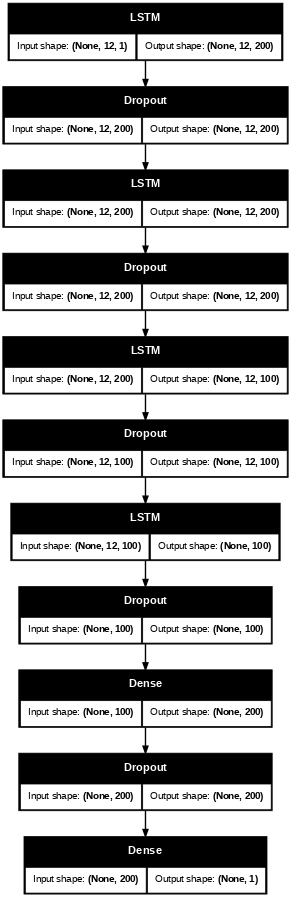

In [ ]:
time_steps = 12
n_features = 1

## Early stopping to allow the model to train until proper convergence
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

#lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
model = build_lstm_model(time_steps, n_features)

## Adam Optimization Used
model.compile(optimizer=Adam(learning_rate=0.0012), loss='mean_squared_error', metrics=['mean_squared_error'])

model.summary()

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, dpi = 50)

# Display the saved plot
Image('model.png')

In [ ]:
history = model.fit(X_traint, y_traint, epochs=500, batch_size=32, validation_data=(X_validt, y_validt), verbose = 1, callbacks=([early_stopping]))

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0743 - mean_squared_error: 0.0743 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 9.1025e-04 - val_mean_squared_error: 9.1025e-04
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 7.0094e-04 - val_mean_squared_error: 7.0094e-04
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0087 - mean_squared_error: 0.0087 

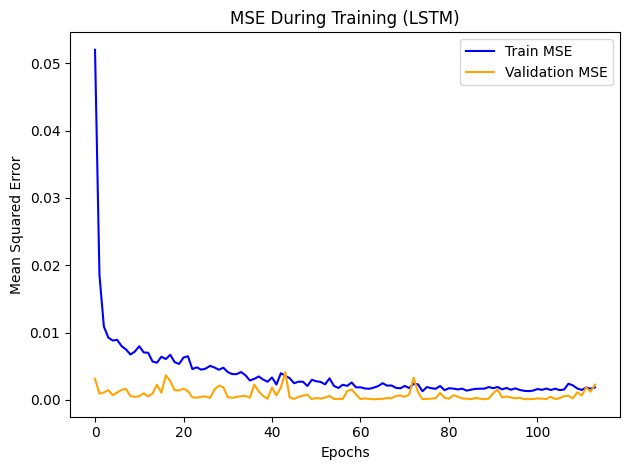

In [ ]:
## Convergence Plot
train_mse = history.history['mean_squared_error']
valid_mse = history.history['val_mean_squared_error']

# Plot MSE

plt.plot(train_mse, label='Train MSE', color='blue')
plt.plot(valid_mse, label='Validation MSE', color='orange')
plt.title('MSE During Training (LSTM)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def mc_conf_int(model, X, scaler, n_samples=1000, ci=95, model_type = 'not_sq'):

  '''
  Input:
  model = model for estimating confidence intervals
  X = Test or Valid X
  Scaler = Scaler used for Min-Max Scaling
  n_sample = how many samples for iteration
  ci = confidence iterval
  model_type = 'not_sq' for all model except Seq2Seq Architectures, 'sq' for Seq2Seq Architecture

  Output:
  mean_prediction = mean prediction
  lower_bound = lower bound of confidence interval
  upper_bound = upper bound of confidence interval


  '''

    def predict_with_dropout(X):
       return model(X, training=True) ## Make predictions using training inference for randomness introduced by batch dropout

    predictions = []
    for _ in range(n_samples):
        pred = predict_with_dropout(X)
        predictions.append(pred.numpy())

    predictions = np.array(predictions)

    if model_type == 'not_sq':
      inverted_predictions = []
      for i in range(predictions.shape[1]):
          timestep_preds = predictions[:, i, :]
          inverted_timestep_preds = scaler.inverse_transform(timestep_preds)
          inverted_predictions.append(inverted_timestep_preds)

      inverted_predictions = np.array(inverted_predictions).transpose(1, 0, 2)

    elif model_type == 'sq':
        inverted_predictions = scaler.inverse_transform(predictions.squeeze(axis=-1).reshape(-1, 1)).reshape(predictions.shape)


    # Calculate percentiles for the confidence interval
    lower_percentile = (100 - ci) / 2
    upper_percentile = 100 - lower_percentile
    lower_bound = np.percentile(inverted_predictions, lower_percentile, axis=0)
    upper_bound = np.percentile(inverted_predictions, upper_percentile, axis=0)

    # Calculate mean prediction
    mean_prediction = np.mean(predictions, axis=0)

    return mean_prediction, lower_bound, upper_bound

In [ ]:

## Preiction Interval for LSTM
m_pred,lower_bound_valid, upper_bound_valid = mc_conf_int(model, X_validt, scaler2)
m_pred, lower_bound_test, upper_bound_test = mc_conf_int(model, X_testt, scaler2)

In [ ]:
## LSTM valid prediction metrics
lstm_valid_predt = model.predict(X_validt)
lstm_valid_predt_u = scaler2.inverse_transform(lstm_valid_predt)
y_validt_u = scaler2.inverse_transform(y_validt)

lstmt_valid_RMSE = np.sqrt(np.mean((y_validt_u - lstm_valid_predt_u)**2))
lstmt_valid_MAE = np.mean(np.abs((y_validt_u- lstm_valid_predt_u)))
lstmt_valid_MPE = np.mean((y_validt_u - lstm_valid_predt_u) / y_validt_u) * 100
lstmt_valid_MAPE = np.mean(np.abs((y_validt_u- lstm_valid_predt_u) / y_validt_u)) * 100
print('LSTMT VALID RMSE:', lstmt_valid_RMSE)
print('LSTMT VALID MAE:', lstmt_valid_MAE)
print('LSTMT VALID MPE:', lstmt_valid_MPE)
print('LSTMT VALID MAPE:', lstmt_valid_MAPE)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
LSTMT VALID RMSE: 0.1786143367521342
LSTMT VALID MAE: 0.12160598115487527
LSTMT VALID MPE: -1.2390378787091445
LSTMT VALID MAPE: 11.636451999085091


In [ ]:
valid_dates = valid_p[valid_p['date'] > '2016-07-1']
valid_dates = valid_dates['date'].reset_index(drop=True)
valid_dates

,date
0,2016-08-01
1,2016-09-01
2,2016-10-01
3,2016-11-01
4,2016-12-01
5,2017-01-01
6,2017-02-01
7,2017-03-01
8,2017-04-01
9,2017-05-01


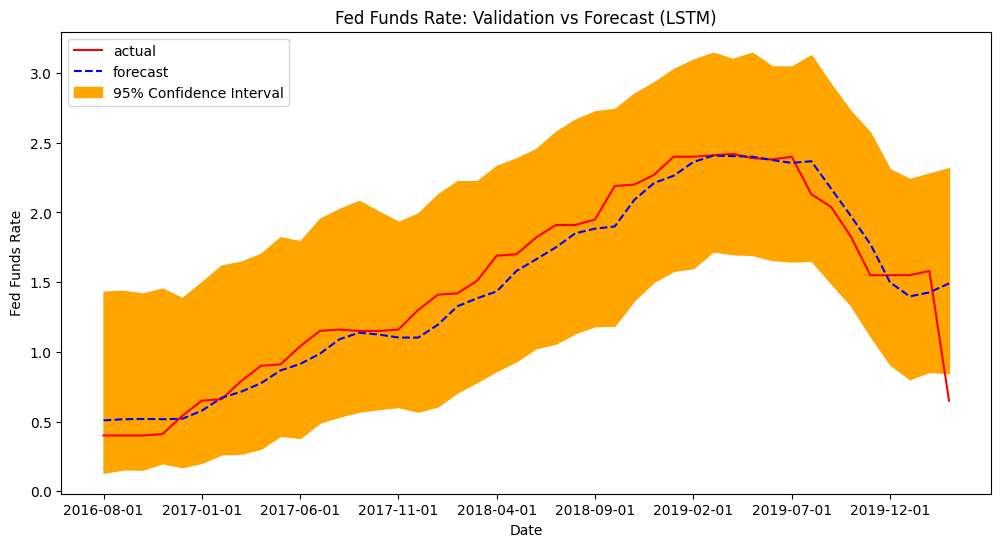

In [ ]:
## LSTM Valid Plot

plt.figure(figsize=(12, 6))
plt.plot(valid_dates, y_validt_u, color = 'r', label='actual')
plt.plot(valid_dates, lstm_valid_predt_u, color='b',  label='forecast', linestyle = '--')
plt.fill_between(valid_dates, lower_bound_valid.flatten(), upper_bound_valid.flatten(), color='orange', alpha=1, label='95% Confidence Interval')
plt.xticks(valid_dates[::5])
plt.xlabel('Date')
plt.ylabel('Fed Funds Rate')
plt.title('Fed Funds Rate: Validation vs Forecast (LSTM)')

plt.legend()

plt.show()


In [ ]:
## Test Predictions

lstm_test_predt = model.predict(X_testt)
lstm_test_predt = scaler2.inverse_transform(lstm_test_predt)
y_testt_u = scaler2.inverse_transform(y_testt)



In [ ]:
test_dates = test_p[test_p['date'] > '2021-03-1']
test_dates = test_dates['date'].reset_index(drop=True)
test_dates

,date
0,2021-04-01
1,2021-05-01
2,2021-06-01
3,2021-07-01
4,2021-08-01
5,2021-09-01
6,2021-10-01
7,2021-11-01
8,2021-12-01
9,2022-01-01


In [ ]:
model.save('model.keras')

import shutil

!zip -r model.zip /content/model.keras

from google.colab import files
files.download('model.zip')

  adding: content/model.keras (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
uploaded = files.upload()



Saving fed_funds_full.csv to fed_funds_full.csv


In [ ]:
import zipfile

with zipfile.ZipFile("model (2).zip", 'r') as zip_ref:
    zip_ref.extractall("model (2)")

from tensorflow import keras

model = keras.models.load_model('model/model.keras') # Use keras.models.load_model


### LSTM Recurssive Forecasts:

After our analysis throughout the notebooks, LSTM was one of the better models and we want to use the model to forecast future dates. We use recurssive forecasts that uses the last available sequence to forecast the next date Fed Funds Rate. We then remove the oldest date observation and replace it with the newest observation.

In [ ]:
fed_funds_current = pd.read_csv('fed_funds_full.csv')
fed_funds_current = fed_funds_current

print(fed_funds_current)
fed_funds_current['FEDFUNDS'] = scaler2.transform(fed_funds_current[['FEDFUNDS']])
print(fed_funds_current)
fed_funds_current = fed_funds_current.drop(columns = ['observation_date'])
fed_funds_current = pd.concat([test_t, fed_funds_current]).reset_index(drop=True)
fed_funds_current = fed_funds_current.tail(58).reset_index(drop=True)
print(fed_funds_current)

    observation_date  FEDFUNDS
0           7/1/1954      0.80
1           8/1/1954      1.22
2           9/1/1954      1.07
3          10/1/1954      0.85
4          11/1/1954      0.83
..               ...       ...
843        10/1/2024      4.83
844        11/1/2024      4.64
845        12/1/2024      4.48
846         1/1/2025      4.33
847         2/1/2025      4.33

[848 rows x 2 columns]
    observation_date  FEDFUNDS
0           7/1/1954  0.038360
1           8/1/1954  0.060431
2           9/1/1954  0.052549
3          10/1/1954  0.040988
4          11/1/1954  0.039937
..               ...       ...
843        10/1/2024  0.250131
844        11/1/2024  0.240147
845        12/1/2024  0.231739
846         1/1/2025  0.223857
847         2/1/2025  0.223857

[848 rows x 2 columns]
    FEDFUNDS
0  -0.001051
1   0.000525
2   0.001051
3   0.001576
4   0.001051
5   0.001051
6   0.001051
7   0.001051
8   0.001051
9   0.000525
10  0.000000
11  0.000000
12 -0.000525
13  0.000525
14  0.001576


In [ ]:
X_testt2, y_testt2 = create_sequences_t(fed_funds_current, n_lags)
X_testt2.shape

(46, 12, 1)

In [ ]:
# Function to recursively predict 60 steps ahead
def forecast_lstm(model, last_sequence, n_forecast, last_date, scaler):

  '''
  Inputs:
  model = LSTM model that will be used in forecasting
  last_sequence = last sequence in the test data
  n_forecast = number of forecasting periods
  last_date = last date in the test data
  scaler = scaler used for Min-Max Scaling

  Output:
  forecast_df = dataframe with date and forecast
  '''
    predictions = []
    current_input = last_sequence.copy()

    for _ in range(n_forecast):
        next_value = model.predict(current_input.reshape(1, -1, 1)) #Prediction
        predictions.append(next_value[0, 0]) #Add prediction to current_input
        current_input = np.append(current_input[1:], next_value) #Remove oldest predictions


    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()


    date_range = pd.date_range(last_date, periods=n_forecast+1, freq='M')[1:]

    forecast_df = pd.DataFrame({'Date': date_range, 'LSTM Forecast': predictions})
    forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])

    return forecast_df






In [ ]:
## 12 Month Forecast

n_forecast = 12*1
last_date = '02-01-2025'

last_seq = X_testt2[-1]

lstm_forecast12 = forecast_lstm(model, last_seq, n_forecast, last_date, scaler2)



lstm_forecast12

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<ipython-input-77-a3bb795ac47c>:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(last_date, periods=n_forecast+1, freq='M')[1:]


,Date,LSTM Forecast
0,2025-03-31,4.263651
1,2025-04-30,4.197560
2,2025-05-31,4.148593
3,2025-06-30,4.104365
4,2025-07-31,4.062166
5,2025-08-31,4.021674
6,2025-09-30,3.983292
7,2025-10-31,3.947484
8,2025-11-30,3.914370
9,2025-12-31,3.883801


In [ ]:
## March Forecast
last_date = '01-01-2025'
last_seq = X_testt2[-1]

lstm_forecast3 = lstm_forecast12.iloc[0]

lstm_forecast3


,0
Date,2025-03-31 00:00:00
LSTM Forecast,4.263651


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

lstm_forecast12.to_csv('/content/drive/MyDrive/lstm_forecast12.csv', index=False)
lstm_forecast3.to_csv('/content/drive/MyDrive/lstm_forecast3.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
lstm_forecast60

,Date,LSTM Forecast
0,2025-03-31,4.211298
1,2025-04-30,4.111128
2,2025-05-31,4.032039
3,2025-06-30,3.971599
4,2025-07-31,3.928067
5,2025-08-31,3.899536
6,2025-09-30,3.883971
7,2025-10-31,3.879478
8,2025-11-30,3.883601
9,2025-12-31,3.894086


In [ ]:
def build_GRU_model(time_steps, n_features):

  '''
  GRU Model

  Inputs:
  time_steps = time steps
  n_features = number of features

  Output:
  GRU model
  '''

  model2 = Sequential()
  model2.add(GRU(units=200, return_sequences=True, input_shape=(time_steps, n_features)))
  model2.add(GRU(units = 200, return_sequences = True))
  model2.add(Dropout(.2))
  model2.add(GRU(units = 100, return_sequences = True))
  model2.add(Dropout(.2))
  model2.add(GRU(units = 100, return_sequences = False))
  model2.add(Dropout(.2))
  model2.add(Dense(200, activation = 'relu'))
  model2.add(Dropout(.2))
  model2.add(Dense(units = 1))
  return model2

In [ ]:
time_steps = 12
n_features = 1

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

model2 = build_GRU_model(time_steps, n_features)

model2.compile(optimizer=Adam(learning_rate=0.0012), loss='mean_squared_error', metrics=['mean_squared_error'])

model2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 12, 200)             │         121,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 12, 200)             │         241,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 12, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 12, 100)             │          90,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 12, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 100)                 │          60,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 200)                 │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 534,601 (2.04 MB)

 Trainable params: 534,601 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history2 = model2.fit(X_traint, y_traint, epochs=500, batch_size=32, validation_data=(X_validt, y_validt), verbose = 1, callbacks=([early_stopping]))

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0527 - mean_squared_error: 0.0527 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 6.0356e-04 - val_mean_squared_error: 6.0356e-04
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 4.8391e-04 - val_mean_squared_error: 4.8391e-04
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 6.6420e-04 - val_mean_squared_error: 6.6420e-04
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 5.0094e-04 - val_mean_squared_error: 5.0094e-04
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 3.4493e-04 - val_mean_squared_error: 3.4493e-04
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0055 - mea

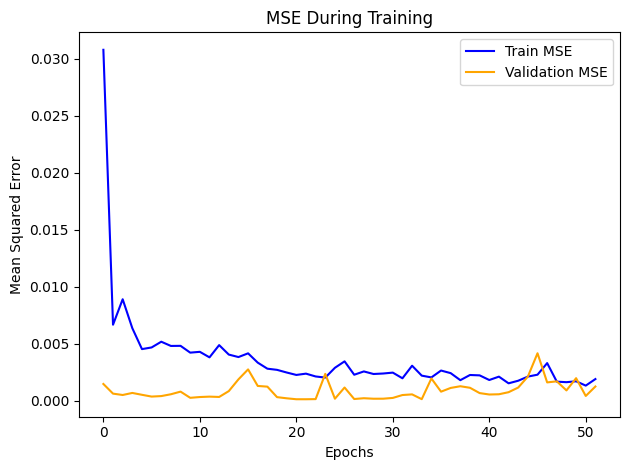

In [ ]:

## Convergence Graph for GRU
train_mse = history2.history['mean_squared_error']
valid_mse = history2.history['val_mean_squared_error']

# Plot MSE

plt.plot(train_mse, label='Train MSE', color='blue')
plt.plot(valid_mse, label='Validation MSE', color='orange')
plt.title('MSE During Training')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
## GRU conf interval
m_pred2, lower_bound_valid2, upper_bound_valid2 = mc_conf_int(model2, X_validt, scaler2)
m_pred2, lower_bound_test2, upper_bound_test2 = mc_conf_int(model2, X_testt, scaler2)

In [ ]:
## GRU valid performance

gru_valid_predt = model2.predict(X_validt)
gru_valid_predt_u = scaler2.inverse_transform(gru_valid_predt)

grut_valid_RMSE = np.sqrt(np.mean((y_validt_u - gru_valid_predt_u)**2))
grut_valid_MAE = np.mean(np.abs((y_validt_u- gru_valid_predt_u)))
grut_valid_MPE = np.mean((y_validt_u - gru_valid_predt_u) / y_validt_u) * 100
grut_valid_MAPE = np.mean(np.abs((y_validt_u- gru_valid_predt_u) / y_validt_u)) * 100
print('GRUT VALID RMSE:', grut_valid_RMSE)
print('GRUT VALID MAE:', grut_valid_MAE)
print('GRUT VALID MPE:', grut_valid_MPE)
print('GRUT VALID MAPE:', grut_valid_MAPE)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
GRUT VALID RMSE: 0.19986980761750084
GRUT VALID MAE: 0.1394477447596463
GRUT VALID MPE: -1.3960902193461937
GRUT VALID MAPE: 12.944352247355988


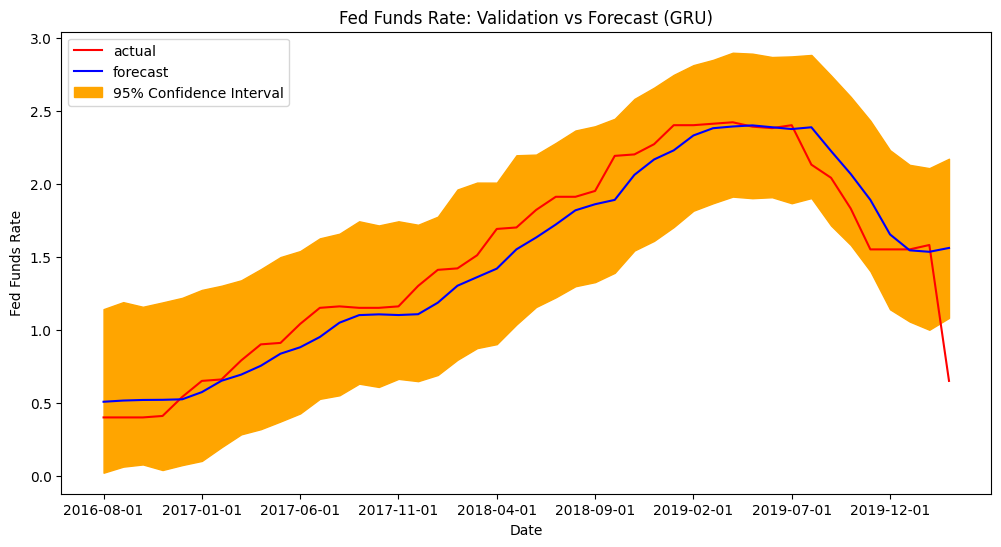

In [ ]:
## GRU Valid Graph vs Fed Funds

plt.figure(figsize=(12, 6))
plt.plot(valid_dates, y_validt_u, color = 'r', label='actual')
plt.plot(valid_dates, gru_valid_predt_u, color='b',  label='forecast')
plt.fill_between(valid_dates, lower_bound_valid2.flatten(), upper_bound_valid2.flatten(), color='orange', alpha=1, label='95% Confidence Interval')
plt.xticks(valid_dates[::5])
plt.xlabel('Date')
plt.ylabel('Fed Funds Rate')
plt.title('Fed Funds Rate: Validation vs Forecast (GRU)')

plt.legend()

plt.show()

In [ ]:
## GRU test predictions
gru_test_predt = model2.predict(X_testt)
gru_test_predt = scaler2.inverse_transform(gru_test_predt)




In [18]:
def build_seq2seq_timemodel(T_in, n_features, T_out):

  '''
  Seq2Seq Model

  Inputs:
  T_in = input time steps
  n_features = number of features
  T_out = output time steps

  Output:
  Seq2Seq model
  '''

    encoder_inputs = Input(shape=(T_in, n_features))
    encoder_lstm = LSTM(256, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)
    encoder_outputs = encoder_lstm(encoder_inputs)


    encoder_lstm2 = LSTM(128, return_state=True, dropout=0.1, recurrent_dropout=0.1)  # Return state for the decoder
    encoder_outputs, state_h, state_c = encoder_lstm2(encoder_outputs)



    decoder_inputs = RepeatVector(T_out)(state_h)

    decoder_lstm = LSTM(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)
    decoder_outputs = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])


    decoder_lstm2 = LSTM(256, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)
    decoder_outputs = decoder_lstm2(decoder_outputs)

    #decoder_dense1 = TimeDistributed(layers.Dense(128, activation="relu"))
    decoder_dense2 = TimeDistributed(Dense(1))
    decoder_outputs = decoder_dense2(decoder_outputs)



    modelt = Model(encoder_inputs, decoder_outputs)

    return modelt

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 12, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_8 (LSTM)             │ (None, 12, 256)        │        264,192 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_9 (LSTM)             │ [(None, 128), (None,   │        197,120 │ lstm_8[0][0]           │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_2           │ (None, 1, 128)         │              0 │ lstm_9[0][1]           │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_10 (LSTM)            │ (None, 1, 128)         │        131,584 │ repeat_vector_2[0][0], │
│                           │                        │                │ lstm_9[0][1],          │
│                           │                        │                │ lstm_9[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_11 (LSTM)            │ (None, 1, 256)         │        394,240 │ lstm_10[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_4        │ (None, 1, 1)           │            257 │ lstm_11[0][0]          │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 987,393 (3.77 MB)

 Trainable params: 987,393 (3.77 MB)

 Non-trainable params: 0 (0.00 B)

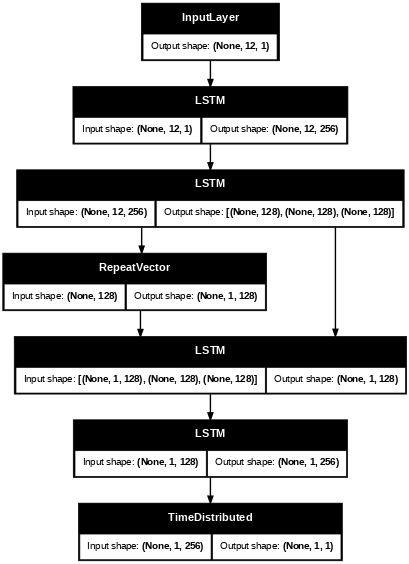

In [19]:
from re import X
T_in = 12  # Input past 12 months
T_out = 1  # Predict next month
n_features = 1

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

#lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
modelt = build_seq2seq_timemodel(T_in, n_features, T_out)

modelt.compile(optimizer=Adam(learning_rate=0.0012), loss='mean_squared_error', metrics=['mean_squared_error'])

modelt.summary()

plot_model(modelt, to_file='modelt.png', show_shapes=True, show_layer_names=False, dpi = 50)

# Display the saved plot
Image('modelt.png')


In [20]:
historyt = modelt.fit(X_traint, y_traint, epochs=500, batch_size=128, validation_data=(X_validt, y_validt), verbose = 1, callbacks=([early_stopping]))

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 825ms/step - loss: 0.1096 - mean_squared_error: 0.1096 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0338 - mean_squared_error: 0.0338 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0332 - mean_squared_error: 0.0332 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0295 - mean_squared_error: 0.0295 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0209 - mean_squared_error: 0.0209 - val_loss: 0.0030 - val_mea

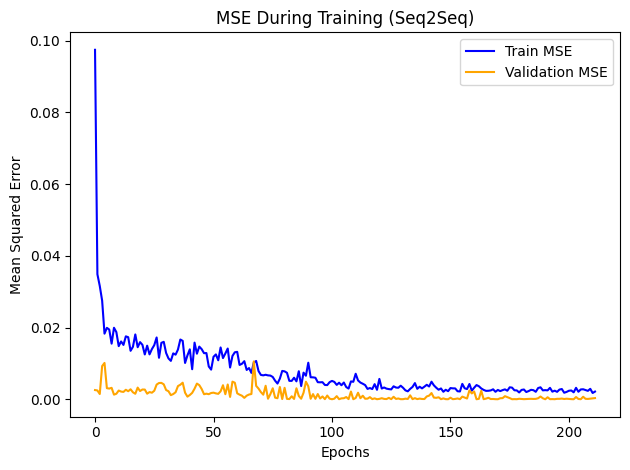

In [21]:
## Training covergence plot for Seq2Seq

train_mse = historyt.history['mean_squared_error']
valid_mse = historyt.history['val_mean_squared_error']

# Plot MSE

plt.plot(train_mse, label='Train MSE', color='blue')
plt.plot(valid_mse, label='Validation MSE', color='orange')
plt.title('MSE During Training (Seq2Seq)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
## Conf Intervals for Seq2Seq
m_predt, lower_bound_validt, upper_bound_validt = mc_conf_int(modelt, X_validt, scaler2, model_type = 'sq')
m_predt, lower_bound_testt, upper_bound_testt = mc_conf_int(modelt, X_testt, scaler2, model_type = 'sq')

In [ ]:

## Valid predictions and metrics for Seq2Seq
seq_valid_predt = modelt.predict(X_validt).reshape(-1, 1)

seq_valid_predt_u = scaler2.inverse_transform(seq_valid_predt)
y_validt_u = scaler2.inverse_transform(y_validt)

seqt_valid_RMSE = np.sqrt(np.mean((y_validt_u - seq_valid_predt_u)**2))
seqt_valid_MAE = np.mean(np.abs((y_validt_u- seq_valid_predt_u)))
seqt_valid_MPE = np.mean((y_validt_u - seq_valid_predt_u) / y_validt_u) * 100
seqt_valid_MAPE = np.mean(np.abs((y_validt_u- seq_valid_predt_u) / y_validt_u)) * 100
print('SEQT VALID RMSE:', seqt_valid_RMSE)
print('SEQT VALID MAE:', seqt_valid_MAE)
print('SEQT VALID MPE:', seqt_valid_MPE)
print('SEQT VALID MAPE:', seqt_valid_MAPE)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
SEQT VALID RMSE: 0.15124473859427628
SEQT VALID MAE: 0.10504069870168514
SEQT VALID MPE: -4.609932845595397
SEQT VALID MAPE: 10.285400168126001


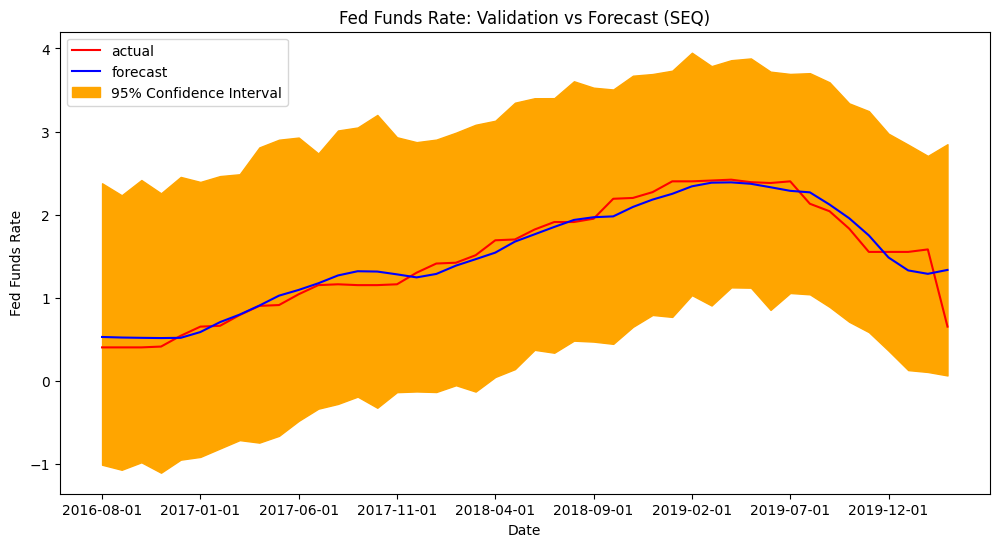

In [ ]:
## Valid prediction graph for Seq2Seq

plt.figure(figsize=(12, 6))
plt.plot(valid_dates, y_validt_u, color = 'r', label='actual')
plt.plot(valid_dates, seq_valid_predt_u, color='b',  label='forecast')
plt.fill_between(valid_dates, lower_bound_validt.flatten(), upper_bound_validt.flatten(), color='orange', alpha=1, label='95% Confidence Interval')
plt.xticks(valid_dates[::5])
plt.xlabel('Date')
plt.ylabel('Fed Funds Rate')
plt.title('Fed Funds Rate: Validation vs Forecast (SEQ)')

plt.legend()

plt.show()

In [ ]:
## Seq2Seq Test Metrics
seq_test_predt = modelt.predict(X_testt).reshape(-1, 1)

seq_test_predt_u = scaler2.inverse_transform(seq_test_predt)
#y_testt_u = scaler2.inverse_transform(y_testt)



### Seq2Seq Recursive Forecasts for future periods

Like the LSTM model, the Seq2Seq model performs well and we use recursive forecasting for future Federal Funds Rate predictions

In [ ]:
def recursive_forecastseq(model, X_start, T_out, scaler, n_months, last_date, n_forecast):

  '''
  Recursive Forecast for Seq2Seq

  Input:
  model = Seq2Seq model
  X_start = last sequence of the test data
  T_out = output time steps
  scaler = scaler used for Min-Max Scaling
  n_months = number of months to forecast
  last_date = last date in the test data
  n_forecast = number of forecasting periods

  Output:
  forecast_df = dataframe with date and forecast

  '''




    all_forecasts = []
    X_current = X_start.copy().reshape(1,12,1)  # Initial window

    for i in range(n_months):
        # Predict next T_out timesteps
        prediction = model.predict(X_current, verbose=0)

        prediction_inv = scaler.inverse_transform(prediction.reshape(-1, 1))
        print(prediction_inv)
        all_forecasts.append(prediction_inv[-1, 0])


        new_input = prediction[:, -1].reshape(1, 1, 1)
        X_current = np.concatenate([X_current[:, 1:, :], new_input], axis=1)
        print(X_current)



    date_range = pd.date_range(last_date, periods=n_forecast+1, freq='M')[1:]

    forecast_df = pd.DataFrame({'Date': date_range, 'seqForecast':all_forecasts })
    forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])



    return forecast_df

In [ ]:
## 12 Month Seq2Seq forecast

T_in = 12
T_out = 1
n_months = 12
last_date = '02-01-2024'
n_forecast = 12


X_start = X_testt2[-1]  # Start from the last input window
seq_forecast12 = recursive_forecastseq(modelt, X_start, T_out, scaler_y, n_months, last_date = last_date, n_forecast=n_forecast)
seq_forecast12

seq_forecast1 = seq_forecast12.iloc[1]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

seq_forecast12.to_csv('/content/drive/MyDrive/seq_forecast12.csv', index=False)

seq_forecast1.to_csv('/content/drive/MyDrive/seq_forecast1.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3. Feature Based Neural Networks

1. CNN-LSTM model - Keras Sequential - 3 CNN layers that have filters of 512, 256, 128 and a kernel of 5, 3, 3 respectively - ReLU activation used in the CNN layers - Batch Normalization used in the CNN layers and batch dropout of 10% in the second and third CNN layers. 5 LSTM layers with units of 400, 400, 400, 200, 100 respectively -  dropout and recurrent dropout of 10% in each LSTM layer - fully connected dense layer with 100 unit and batch dropout of 10%.

2. Seq2Seq (features) - Keras Sequential - 1 encoder LSTM layer with units of 1024 and batch dropout and recurrent dropout of 10% - 1 decoder LSTM layer with units of 1024 and batch dropout and recurrent dropout of 10% - time distributed output.

In [ ]:
def build_cnn_lstm_model(time_steps, n_features):

  '''
  CNN-LSTM Model

  Inputs:
  time_steps = time steps
  n_features = number of features

  Output:
  CNN-LSTM model
  '''
    model5 = Sequential()

    model5.add(Conv1D(filters=512, kernel_size=5, activation='relu', input_shape=(time_steps, n_features)))
    model5.add(BatchNormalization())

    model5.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
    model5.add(Dropout(0.1))
    model5.add(BatchNormalization())

    model5.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model5.add(Dropout(0.1))
    model5.add(BatchNormalization())

    #model5.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    #model5.add(Dropout(0.1))
    #model5.add(BatchNormalization())

    #model5.add(MaxPooling1D(pool_size=2))



    model5.add(Bidirectional(LSTM(400, return_sequences=True, dropout=0.1, recurrent_dropout=.1)))
    model5.add(Bidirectional(LSTM(400, return_sequences=True, dropout=0.1, recurrent_dropout=.1)))
    model5.add(Bidirectional(LSTM(400, return_sequences=True, dropout=0.1, recurrent_dropout=.1)))
    model5.add(Bidirectional(LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=.1)))
    model5.add(Bidirectional(LSTM(100, return_sequences= False, dropout=0.1, recurrent_dropout=.1)))

    model5.add(Dense(100, activation='relu'))
    model5.add(Dropout(0.1))
    model5.add(Dense(1))

    return model5

In [ ]:
time_steps = 12
n_features=X_train_seq.shape[2]

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=100,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5) ## LR scheduler used to drop global learning rate for Adam optimizer due to the struggle for this model to converge
model5 = build_cnn_lstm_model(time_steps, n_features)

model5.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error'])

model5.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 8, 512)              │          90,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 512)              │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 4, 256)              │         655,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 4, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 4, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 2, 128)              │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 2, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 2, 800)              │       1,692,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 2, 800)              │       3,843,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 2, 800)              │       3,843,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 2, 400)              │       1,601,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 200)                 │         400,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,249,545 (46.73 MB)

 Trainable params: 12,247,753 (46.72 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
history5 = model5.fit(X_train_seq, y_train_seq, epochs=500, batch_size=128, validation_data=(X_valid_seq, y_valid_seq), verbose = 1, callbacks=([early_stopping,lr_scheduler]))

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - loss: 0.1006 - mean_squared_error: 0.1006 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - learning_rate: 0.0010
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0997 - mean_squared_error: 0.0997 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - learning_rate: 0.0010
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - learning_rate: 0.0010
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0221 - mean_squared_error: 0.0221 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - learning_rate: 0.0010
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - learning_rate: 0.0010
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 

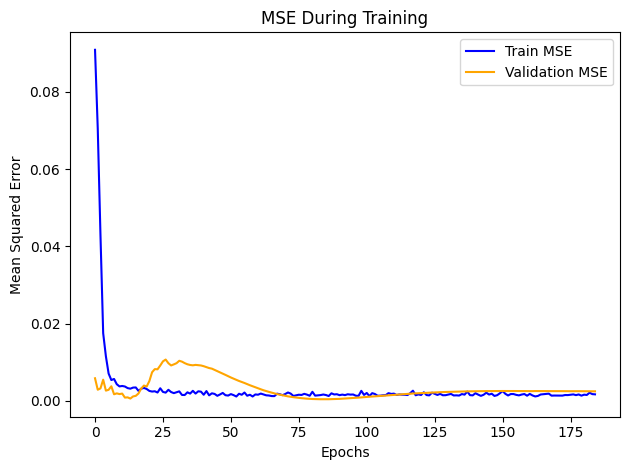

In [ ]:
## Convergence Plot for CNN-LSTM
train_mse = history5.history['mean_squared_error']
valid_mse = history5.history['val_mean_squared_error']

# Plot MSE

plt.plot(train_mse, label='Train MSE', color='blue')
plt.plot(valid_mse, label='Validation MSE', color='orange')
plt.title('MSE During Training')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# CNN-LSTM confidence intervals
m_pred5, lower_bound_valid5, upper_bound_valid5 = mc_conf_int(model5, X_valid_seq, scaler_y)
m_pred5, lower_bound_test5, upper_bound_test5 = mc_conf_int(model5, X_test_seq, scaler_y)

In [ ]:
## Valid predictions and validation performance metrics for CNN-LSTM

cnnlstm_valid_predp = model5.predict(X_valid_seq)

cnnlstm_valid_pred_p = scaler_y.inverse_transform(cnnlstm_valid_predp)
y_valid_seqp = scaler_y.inverse_transform(y_valid_seq)


cnnlstm_valid_RMSE = np.sqrt(np.mean((y_valid_seqp - cnnlstm_valid_pred_p)**2))
cnnlstm_valid_MAE = np.mean(np.abs((y_valid_seqp- cnnlstm_valid_pred_p)))
cnnlstm_valid_MPE = np.mean((y_valid_seqp - cnnlstm_valid_pred_p) / y_valid_seqp) * 100
cnnlstm_valid_MAPE = np.mean(np.abs((y_valid_seqp- cnnlstm_valid_pred_p) / y_valid_seqp)) * 100
print('CNNLSTM VALID RMSE:', cnnlstm_valid_RMSE)
print('CNNLSTM VALID MAE:', cnnlstm_valid_MAE)
print('CNNLSTM VALID MPE:', cnnlstm_valid_MPE)
print('CNNLSTM VALID MAPE:', cnnlstm_valid_MAPE)

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
CNNLSTM VALID RMSE: 0.3786714227624609
CNNLSTM VALID MAE: 0.3154846323620189
CNNLSTM VALID MPE: -18.057884040675045
CNNLSTM VALID MAPE: 33.26545026688228


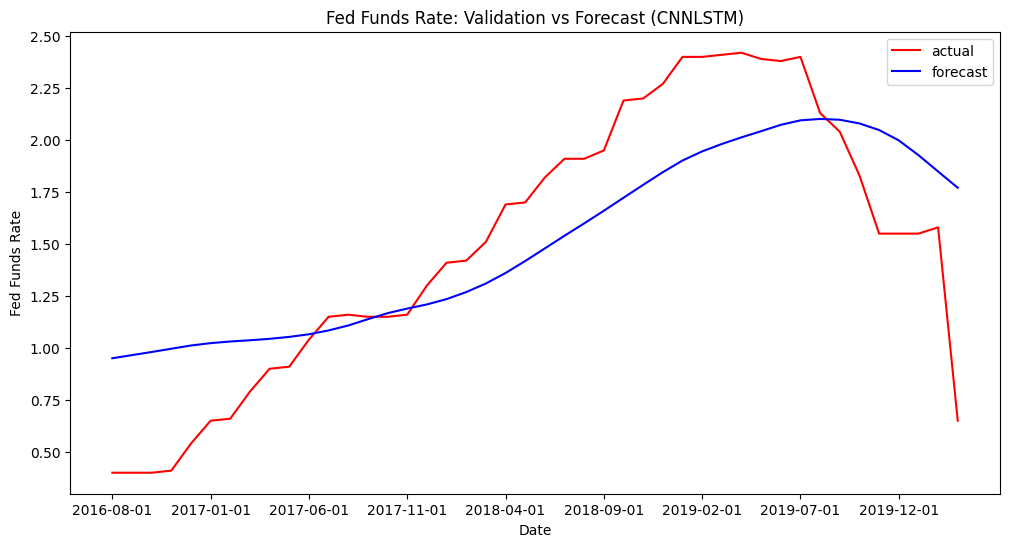

In [ ]:
## CNN-LSTM valid plot

plt.figure(figsize=(12, 6))
plt.plot(valid_dates, y_valid_seqp, color = 'r', label='actual')
plt.plot(valid_dates, cnnlstm_valid_pred_p, color='b',  label='forecast')
#plt.fill_between(valid_dates, lower_bound_valid5.flatten(), upper_bound_valid5.flatten(), color='orange', alpha=1, label='95% Confidence Interval')
plt.xticks(valid_dates[::5])
plt.xlabel('Date')
plt.ylabel('Fed Funds Rate')
plt.title('Fed Funds Rate: Validation vs Forecast (CNNLSTM)')

plt.legend()

plt.show()

In [ ]:
## Test Predictions

cnnlstm_test_predp = model5.predict(X_test_seq)

cnnlstm_test_pred_p = scaler_y.inverse_transform(cnnlstm_test_predp)
y_test_seqp = scaler_y.inverse_transform(y_test_seq)

mask = np.isnan(cnnlstm_test_pred_p)
cnnlstm_test_pred_p[mask] = -.00436916




In [ ]:
def build_seq2seq_model(T_in, n_features, T_out):

  '''
  Seq2Seq Model

  Inputs:
  T_in = input time steps
  n_features = number of features
  T_out = output time steps

  Output:
  Seq2Seq model
  '''

    encoder_inputs = Input(shape=(T_in, n_features))
    encoder_lstm = LSTM(1024, return_state=True, dropout=0.1, recurrent_dropout=0.1)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)


    decoder_inputs = RepeatVector(T_out)(state_h)


    decoder_lstm = LSTM(1024, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)
    decoder_outputs = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])


    decoder_dense = TimeDistributed(Dense(1))
    decoder_outputs = decoder_dense(decoder_outputs)


    model6 = Model(encoder_inputs, decoder_outputs)

    return model6

In [ ]:
from re import X
T_in = 12  # Input past 12 months
T_out = 1  # Predict next 6 months
n_features = X_train_seq.shape[2]

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=100,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
model6 = build_seq2seq_model(T_in, n_features, T_out)

model6.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error'])

model6.summary()


Model: "functional_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 12, 35)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_42 (LSTM)            │ [(None, 1024), (None,  │      4,341,760 │ input_layer_11[0][0]   │
│                           │ 1024), (None, 1024)]   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_6           │ (None, 1, 1024)        │              0 │ lstm_42[0][1]          │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_43 (LSTM)            │ (None, 1, 1024)        │      8,392,704 │ repeat_vector_6[0][0], │
│                           │                        │                │ lstm_42[0][1],         │
│                           │                        │                │ lstm_42[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_12       │ (None, 1, 1)           │          1,025 │ lstm_43[0][0]          │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 12,735,489 (48.58 MB)

 Trainable params: 12,735,489 (48.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history6 = model6.fit(X_train_seq, y_train_seq, epochs=500, batch_size=32, validation_data=(X_valid_seq, y_valid_seq), verbose = 1, callbacks=([early_stopping,lr_scheduler]))

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - loss: 0.8826 - mean_squared_error: 0.8826 - val_loss: 0.0532 - val_mean_squared_error: 0.0532 - learning_rate: 0.0010
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - learning_rate: 0.0010
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - learning_rate: 0.0010
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 3.5786e-04 - val_mean_squared_error: 3.5786e-04 - learning_rate: 0.0010
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 6.5864e-04 - val_mean_squared_error: 6.5864e-04 - learning_rate: 0.0010
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 6.0639e-04 - va

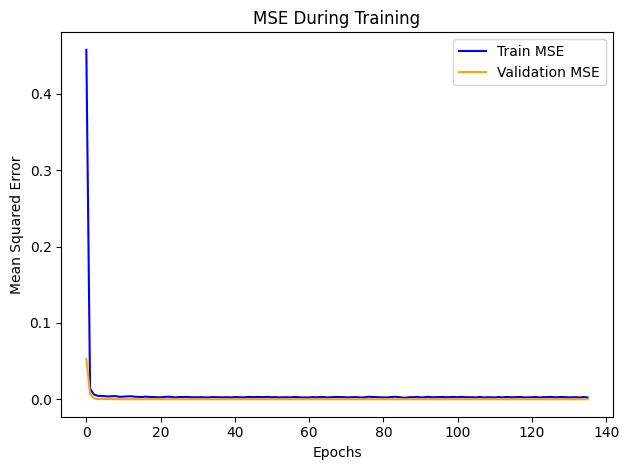

In [ ]:
## Convergence plot for Seq2Seq Feature model

train_mse = history6.history['mean_squared_error']
valid_mse = history6.history['val_mean_squared_error']

# Plot MSE

plt.plot(train_mse, label='Train MSE', color='blue')
plt.plot(valid_mse, label='Validation MSE', color='orange')
plt.title('MSE During Training')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
## Seq2Seq Feature Confidence Intervals

m_predt, lower_bound_valid6, upper_bound_valid6 = mc_conf_int(model6, X_valid_seq, scaler_y, model_type = 'sq')
m_predt, lower_bound_test6, upper_bound_test6 = mc_conf_int(model6, X_test_seq, scaler_y, model_type = 'sq')

In [ ]:
## Seq2Seq valid predictions and performance metrics

seq2seq_valid_predp = model6.predict(X_valid_seq).reshape(-1, 1)
print(seq2seq_valid_predp)
seq2seq_valid_pred_p = scaler_y.inverse_transform(seq2seq_valid_predp)
print(seq2seq_valid_pred_p)
y_valid_seqp = scaler_y.inverse_transform(y_valid_seq)


seq2seq_valid_RMSE = np.sqrt(np.mean((y_valid_seqp - seq2seq_valid_pred_p)**2))
seq2seq_valid_MAE = np.mean(np.abs((y_valid_seqp- seq2seq_valid_pred_p)))
seq2seq_valid_MPE = np.mean((y_valid_seqp - seq2seq_valid_pred_p) / y_valid_seqp) * 100
seq2seq_valid_MAPE = np.mean(np.abs((y_valid_seqp- seq2seq_valid_pred_p) / y_valid_seqp)) * 100
print('SEQ2SEQ VALID RMSE:', seq2seq_valid_RMSE)
print('SEQ2SEQ VALID MAE:', seq2seq_valid_MAE)
print('SEQ2SEQ VALID MPE:', seq2seq_valid_MPE)
print('SEQ2SEQ VALID MAPE:', seq2seq_valid_MAPE)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
[[0.02090756]
 [0.02168405]
 [0.02283974]
 [0.02313128]
 [0.022499  ]
 [0.02437311]
 [0.02857528]
 [0.03027293]
 [0.0331871 ]
 [0.04005339]
 [0.043238  ]
 [0.0476412 ]
 [0.0498981 ]
 [0.05141953]
 [0.0503552 ]
 [0.05330519]
 [0.05650424]
 [0.06203964]
 [0.06640105]
 [0.06977257]
 [0.07486686]
 [0.08306091]
 [0.08613674]
 [0.09048231]
 [0.09421417]
 [0.09826072]
 [0.1010121 ]
 [0.10533729]
 [0.10633123]
 [0.11000585]
 [0.1140223 ]
 [0.11406501]
 [0.11522097]
 [0.11690418]
 [0.11610085]
 [0.1164661 ]
 [0.11599965]
 [0.11044843]
 [0.10737866]
 [0.10135581]
 [0.09488158]
 [0.09090693]
 [0.08974518]
 [0.08962657]]
[[0.46787083]
 [0.48264754]
 [0.5046402 ]
 [0.5101882 ]
 [0.49815586]
 [0.5338202 ]
 [0.61378765]
 [0.64609385]
 [0.70155054]
 [0.832216  ]
 [0.8928192 ]
 [0.9766121 ]
 [1.0195609 ]
 [1.0485137 ]
 [1.0282594 ]
 [1.0843977 ]
 [1.1452757 ]
 [1.2506144 ]
 [1.333612  ]
 [1.3977721 ]
 [1.4947164 ]
 [1.6506491 ]
 [1.7091823 ]
 [1.7918783 ]
 [1.8628

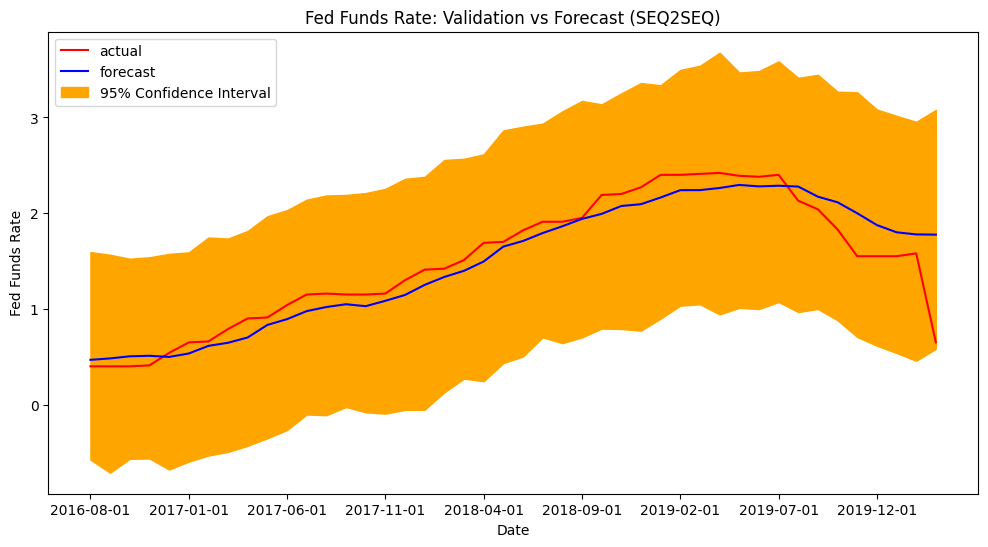

In [ ]:
## Seq2Seq featur model valid chart

plt.figure(figsize=(12, 6))
plt.plot(valid_dates, y_valid_seqp, color = 'r', label='actual')
plt.plot(valid_dates, seq2seq_valid_pred_p, color='b',  label='forecast')
plt.fill_between(valid_dates, lower_bound_valid6.flatten(), upper_bound_valid6.flatten(), color='orange', alpha=1, label='95% Confidence Interval')
plt.xticks(valid_dates[::5])
plt.xlabel('Date')
plt.ylabel('Fed Funds Rate')
plt.title('Fed Funds Rate: Validation vs Forecast (SEQ2SEQ)')

plt.legend()

plt.show()

In [ ]:
## Seq2Seq test predictions

seq2seq_test_predp = model6.predict(X_test_seq).reshape(-1, 1)
seq2seq_test_pred_p = scaler_y.inverse_transform(seq2seq_test_predp)
#y_test_seqp = scaler_y.inverse_transform(y_test_seq)

mask = np.isnan(seq2seq_test_pred_p)
seq2seq_test_pred_p[mask] = -0.60516




In [ ]:
nnn_predictions_valid = pd.DataFrame({'date': valid_dates,'actual' : y_valid_seqp.flatten(), 'lstm' : lstm_valid_predt_u.flatten(), 'gru': gru_valid_predt_u.flatten(), 'seq2seq_uni':seq_valid_predt_u.flatten(), 'cnnlstm':cnnlstm_valid_pred_p.flatten(), 'seq2seq_var': seq2seq_valid_pred_p.flatten() })
nnn_predictions_valid

,date,actual,lstm,gru,seq2seq_uni,cnnlstm,seq2seq_var
0,2016-08-01,0.40,0.508450,0.507174,0.525604,0.950514,0.467871
1,2016-09-01,0.40,0.516481,0.515486,0.518894,0.965672,0.482648
2,2016-10-01,0.40,0.518506,0.519552,0.515191,0.980594,0.504640
3,2016-11-01,0.41,0.516845,0.520548,0.512514,0.996365,0.510188
4,2016-12-01,0.54,0.519460,0.524027,0.515319,1.011885,0.498156
5,2017-01-01,0.65,0.578020,0.573200,0.584901,1.023235,0.533820
6,2017-02-01,0.66,0.670231,0.650951,0.704248,1.031192,0.613788
7,2017-03-01,0.79,0.714018,0.693028,0.795067,1.037090,0.646094
8,2017-04-01,0.90,0.774541,0.753646,0.903620,1.043965,0.701551
9,2017-05-01,0.91,0.866521,0.836149,1.023160,1.053308,0.832216


In [ ]:
nnn_predictions_test = pd.DataFrame({'date': test_dates, 'actual' : y_test_seqp.flatten(), 'lstm' : lstm_test_predt.flatten(), 'gru_t': gru_test_predt.flatten(), 'seq2seq_uni':seq_test_predt_u.flatten(), 'cnnlstm':cnnlstm_test_pred_p.flatten(), 'seq2seq_var': seq2seq_test_pred_p.flatten() })


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
nnn_predictions_valid.to_csv('/content/drive/MyDrive/nnn_predictions_valid.csv', index=False)
nnn_predictions_test.to_csv('/content/drive/MyDrive/nnn_predictions_test.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
conf_int_dfnn_val = pd.DataFrame({'date': valid_dates, 'lstm_lower': lower_bound_valid.flatten(), 'lstm_upper': upper_bound_valid.flatten(), 'gru_lower': lower_bound_valid2.flatten(), 'gru_upper': upper_bound_valid2.flatten(), 'seq2sequ_lower': lower_bound_validt.flatten(), 'seq2sequ_upper': upper_bound_validt.flatten(), 'cnn_lstm_lower': lower_bound_valid5.flatten(), 'cnn_lstm_upper': upper_bound_valid5.flatten(), 'seq2seq_lower': lower_bound_valid6.flatten(), 'seq2seq_upper': upper_bound_valid6.flatten()})
conf_int_dfnn_test = pd.DataFrame({'date': test_dates, 'lstm_lower': lower_bound_test.flatten(), 'lstm_upper': upper_bound_test.flatten(), 'gru_lower': lower_bound_test2.flatten(), 'gru_upper': upper_bound_test2.flatten(), 'seq2sequ_lower': lower_bound_test.flatten(), 'seq2sequ_upper': upper_bound_testt.flatten(), 'cnn_lstm_lower': lower_bound_test5.flatten(), 'cnn_lstm_upper': upper_bound_test5.flatten(), 'seq2seq_lower': lower_bound_test6.flatten(), 'seq2seq_upper': upper_bound_test6.flatten()})
conf_int_dfnn_val.to_csv('/content/drive/MyDrive/conf_int_dfnn_val.csv', index=False)
conf_int_dfnn_test.to_csv('/content/drive/MyDrive/conf_int_dfnn_test.csv', index=False)
conf_int_dfnn_val

,date,lstm_lower,lstm_upper,gru_lower,gru_upper,seq2sequ_lower,seq2seq_upper,cnn_lstm_lower,cnn_lstm_upper,seq2seq_lower
0,2016-08-01,0.132850,1.431287,0.021576,1.141143,-1.013364,1.593582,-0.090919,0.456081,-0.574849
1,2016-09-01,0.156812,1.437755,0.063004,1.189051,-1.074092,1.565152,-0.029529,0.514381,-0.711206
2,2016-10-01,0.155342,1.417982,0.078103,1.157226,-0.983957,1.523871,0.010147,0.571705,-0.566239
3,2016-11-01,0.200944,1.453735,0.039933,1.187143,-1.109487,1.538868,0.019660,0.602273,-0.561751
4,2016-12-01,0.173086,1.385828,0.073676,1.218441,-0.952391,1.574736,0.056969,0.630894,-0.677909
5,2017-01-01,0.204172,1.500650,0.102289,1.272616,-0.919110,1.590154,0.071857,0.648349,-0.595128
6,2017-02-01,0.264425,1.618718,0.196007,1.301252,-0.817812,1.745471,0.051568,0.711777,-0.531083
7,2017-03-01,0.269834,1.646819,0.284106,1.338498,-0.716889,1.734889,0.046323,0.658502,-0.493708
8,2017-04-01,0.304846,1.702672,0.319542,1.414835,-0.747097,1.814603,0.049420,0.692453,-0.429765
9,2017-05-01,0.398673,1.822615,0.372241,1.497458,-0.665395,1.967693,0.057666,0.699067,-0.350936


In [ ]:
valid_performance_nnn = pd.DataFrame({'RMSE': [lstmt_valid_RMSE, grut_valid_RMSE,seqt_valid_RMSE, cnnlstm_valid_RMSE, seq2seq_valid_RMSE ],
                                     'MAE': [lstmt_valid_MAE, grut_valid_MAE, seqt_valid_MAE, cnnlstm_valid_MAE, seq2seq_valid_MAE],
                                     'MPE': [lstmt_valid_MPE, grut_valid_MPE, seqt_valid_MPE, cnnlstm_valid_MPE, seq2seq_valid_MPE],
                                     'MAPE': [lstmt_valid_MAPE, grut_valid_MAPE, seqt_valid_MAPE, cnnlstm_valid_MAPE, seq2seq_valid_MAPE]
                                  })

valid_performance_nnn.index = ['LSTM', 'GRU', 'SEQ2SEQ_UNI', 'CNNLSTM', 'SEQ2SEQ_VAR']
print(valid_performance_nnn)

drive.mount('/content/drive')
valid_performance_nnn.to_csv('/content/drive/MyDrive/valid_performance_nnn.csv', index=False)


                 RMSE       MAE        MPE       MAPE
LSTM         0.178614  0.121606  -1.239038  11.636452
GRU          0.199870  0.139448  -1.396090  12.944352
SEQ2SEQ_UNI  0.151245  0.105041  -4.609933  10.285400
CNNLSTM      0.378671  0.315485 -18.057884  33.265450
SEQ2SEQ_VAR  0.233813  0.164233  -2.005009  14.762129
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def test_metrics(y_test, y_pred):
  '''
  Test metrics for the models

  Inputs:
  y_test = actual values
  y_pred = predicted values

  Output:
  rmse = root mean squared error
  mae = mean absolute error
  mpe = mean percentage error
  mape = mean absolute percentage error
  '''
    rmse = np.sqrt(np.mean((y_test - y_pred)**2))
    mae = np.mean(np.abs((y_test- y_pred)))
    mpe = np.mean((y_test - y_pred) / y_test) * 100
    mape = np.mean(np.abs((y_test- y_pred) / y_test)) * 100
    return rmse, mae, mpe, mape


In [ ]:

lstmt_test_RMSE, lstmt_test_MAE, lstmt_test_MPE, lstmt_test_MAPE = test_metrics(y_testt_u, lstm_test_predt)
gru_test_RMSE, gru_test_MAE, gru_test_MPE, gru_test_MAPE = test_metrics(y_testt_u, gru_test_predt)
seqt_test_RMSE, seqt_test_MAE, seqt_test_MPE, seqt_test_MAPE = test_metrics(y_testt_u, seq_test_predt_u)
cnnlstm_test_RMSE, cnnlstm_test_MAE, cnnlstm_test_MPE, cnnlstm_test_MAPE = test_metrics(y_test_seqp, cnnlstm_test_pred_p)
seq2seq_test_RMSE, seq2seq_test_MAE, seq2seq_test_MPE, seq2seq_test_MAPE = test_metrics(y_test_seqp, seq2seq_test_pred_p)

In [ ]:
test_performance_nnn = pd.DataFrame({'RMSE': [lstmt_test_RMSE, gru_test_RMSE, seqt_test_RMSE, cnnlstm_test_RMSE, seq2seq_test_RMSE ],
                                     'MAE': [lstmt_test_MAE, gru_test_MAE, seqt_test_MAE, cnnlstm_test_MAE, seq2seq_test_MAE],
                                     'MPE': [lstmt_test_MPE, gru_test_MPE, seqt_test_MPE, cnnlstm_test_MPE, seq2seq_test_MPE],
                                     'MAPE': [lstmt_test_MAPE, gru_test_MAPE, seqt_test_MAPE, cnnlstm_test_MAPE, seq2seq_test_MAPE]
                                  })

test_performance_nnn.index = ['LSTM', 'GRU', 'SEQ2SEQ_UNI', 'CNNLSTM', 'SEQ2SEQ']


drive.mount('/content/drive')
test_performance_nnn.to_csv('/content/drive/MyDrive/test_performance_nnn.csv', index=False)


                 RMSE       MAE         MPE        MAPE
LSTM         0.269778  0.220666  -79.868477   90.822533
GRU          0.355460  0.267100  -71.211289   85.319572
SEQ2SEQ_UNI  0.278963  0.235443  -38.062886   50.577182
CNNLSTM      1.093705  0.960841 -126.516615  176.603910
SEQ2SEQ      1.742619  1.602484  252.433816  252.433816
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
